In [ ]:
!pip install nengo-dl

     |████████████████████████████████| 284 kB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 523 kB 36.4 MB/s 
  Created wheel for nengo-dl: filename=nengo_dl-3.4.3-py3-none-any.whl size=205217 sha256=519fbf02eb646dcd19ab6e50919ee9be64dc618c0debfa1bb95172691adf97cf
  Stored in directory: /root/.cache/pip/wheels/f8/9f/d7/05a384373b7813864be0052888ab464b46b1f425634e6fe925
Successfully built nengo-dl
  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [ ]:
!rm -r '/content/First time/'

In [ ]:
!pip install keras-spiking


In [ ]:
%matplotlib inline

from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from keras import *
from keras.layers import *
import nengo
import numpy as np
import tensorflow as tf
import keras_spiking
import warnings
import nengo_dl
from nengo_dl.graph_optimizer import remove_unmodified_resets,remove_zero_incs, remove_identity_muls, remove_constant_copies, remove_reset_incs
from nengo_dl.graph_optimizer import noop_planner
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape((train_images.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))

train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 1, 784) (60000, 1, 1) (10000, 1, 784) (10000, 1, 1)


In [ ]:
model_list = []

In [ ]:
print(train_images.shape)

(60000, 1, 784)


In [ ]:
# AlexNet 

inp = tf.keras.Input(shape=(28, 28, 1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=24,
    kernel_size=11,
    strides=4,
    activation=tf.nn.relu,
    padding='same',
)(inp)

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=5,
    strides=1,
    padding='same',
    activation=tf.nn.relu,
)(conv0)

pool0=tf.keras.layers.AveragePooling2D(
    pool_size=2,
    strides=2,
)(conv1)

conv2=tf.keras.layers.Conv2D(
    filters=96, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation=tf.nn.relu,
)(pool0)

pool1=tf.keras.layers.AveragePooling2D(
    pool_size=2,
    strides=2,
)(conv2)

conv3=tf.keras.layers.Conv2D(
    filters=96,
    kernel_size=3,
    strides=1,
    padding='same',
    activation=tf.nn.relu,
)(pool1)

conv4=tf.keras.layers.Conv2D(
    filters=24,
    kernel_size=3,
    strides=1,
    padding='same',
    activation=tf.nn.relu,
)(conv3)

# fully connected layer
flatten = tf.keras.layers.Flatten()(conv4)
dense0 = tf.keras.layers.Dense(units=1024)(flatten)
dense1=tf.keras.layers.Dense(units=1024)(dense0)
dense2=tf.keras.layers.Dense(units=250)(dense1)
dense=tf.keras.layers.Dense(units=10)(dense2)

model = tf.keras.Model(inputs=inp, outputs=dense)
model.summary()
model_list.append(model)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 24)          2928      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 7, 7, 64)          38464     
_________________________________________________________________
average_pooling2d_22 (Averag (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 3, 3, 96)          55392     
_________________________________________________________________
average_pooling2d_23 (Averag (None, 1, 1, 96)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 1, 1, 96)          830

**Note: Need to add time dimension because SNN
operation is depend on temporal side**

In [ ]:
# VGG5
input = tf.keras.layers.Input(shape = (28,28,1))

conv0 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation=tf.nn.relu)(input)
avgpool0 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv0)
conv1 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation=tf.nn.relu)(avgpool0)
conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation=tf.nn.relu)(conv1)
avgpool1 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv2)
flatten = tf.keras.layers.Flatten()(avgpool1)

# dense0 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)(flatten)
dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(flatten)
output = tf.keras.layers.Dense(units=10)(dense1)
vgg5 = tf.keras.Model(inputs = input, outputs = output, name = "vgg5")
vgg5.summary()
model_list.append(vgg5)

Model: "vgg5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0      

In [ ]:
# VGG9
input = tf.keras.layers.Input(shape =(28,28,1))
conv0 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation=tf.nn.relu)(input)
avgpool0 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv0)
conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation=tf.nn.relu)(avgpool0)
conv3 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation=tf.nn.relu)(conv2)
avgpool1 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv3)
conv4 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding="same", activation=tf.nn.relu)(avgpool1)
conv5 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding="same", activation=tf.nn.relu)(conv4)
avgpool2 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv5)
conv6 = tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding ='same',activation=tf.nn.relu)(avgpool2)
conv7 = tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding ='same',activation=tf.nn.relu)(conv6)
avgpool3 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv7)
flatten = tf.keras.layers.Flatten()(avgpool3)
dense1 = tf.keras.layers.Dense(units=128, activation = tf.nn.relu)(flatten)
output = tf.keras.layers.Dense(units=10)(dense1)
vgg9 = tf.keras.Model(inputs=input, outputs=output, name = "vgg9")
vgg9.summary()
model_list.append(vgg9)

Model: "vgg9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
average_pooling2d_3 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         73856  

In [ ]:
# VGG11
input = tf.keras.layers.Input(shape =(28,28,1))
conv0 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation=tf.nn.relu)(input)
conv1 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation=tf.nn.relu)(conv0)
avgpool0 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv1)
conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation=tf.nn.relu)(avgpool0)
conv3 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation=tf.nn.relu)(conv2)
avgpool1 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv3)
conv4 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding="same", activation=tf.nn.relu)(avgpool1)
conv5 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding="same", activation=tf.nn.relu)(conv4)
avgpool2 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv5)
conv7 = tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding ='same',activation=tf.nn.relu)(avgpool2)
conv8 = tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding ='same',activation=tf.nn.relu)(conv7)
avgpool3 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv8)
flatten = tf.keras.layers.Flatten()(avgpool3)
dense1 = tf.keras.layers.Dense(units=128)(flatten)
output = tf.keras.layers.Dense(units=10)(dense1)
vgg11 = tf.keras.Model(inputs=input, outputs=output, name = "vgg11")
vgg11.summary()
model_list.append(vgg11)

Model: "vgg11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
average_pooling2d_6 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
average_pooling2d_7 (Average (None, 7, 7, 64)          0     

In [ ]:
#VGG 13
input = tf.keras.layers.Input(shape = (28,28,1))

conv0 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation=tf.nn.relu)(input)
conv1 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation=tf.nn.relu)(conv0)
avgpool0 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv1)

conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(avgpool0)
conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(conv2)
avgpool1 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv3)

conv4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation= tf.nn.relu)(avgpool1)
conv5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation= tf.nn.relu)(conv4)
conv6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation= tf.nn.relu)(conv5)
avgpool2 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv6)

conv7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation= tf.nn.relu)(avgpool2)
conv8 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation= tf.nn.relu)(conv7)
conv9 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation= tf.nn.relu)(conv8)
avgpool3 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2)(conv9)
"""
conv10 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation= tf.nn.relu)(avgpool3)
conv11 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation= tf.nn.relu)(conv10)
conv12 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation= tf.nn.relu)(conv11)
avgpool4 = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2, padding = 'same')(conv12)
"""
flatten = tf.keras.layers.Flatten()(avgpool3)
dense0 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(flatten)
dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(dense0)
output = tf.keras.layers.Dense(units=10)(dense1)

vgg13 = tf.keras.Model(inputs = input, outputs = output, name = "vgg13")
vgg13.summary()
model_list.append(vgg13)

Model: "vgg13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
average_pooling2d_10 (Averag (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
average_pooling2d_11 (Averag (None, 7, 7, 64)          0     

In [ ]:
for model in model_list:
  for scale in [2,5,10,20]:
    print("Model: "+ model.name + " Scale: "+ str(scale))
    energy = keras_spiking.ModelEnergy(model, example_data=np.ones((32, 28, 28, 1)) * scale)
    energy.summary(
        columns=(
            "name",
            "rate",
            "energy cpu",
            "energy gpu",
            "energy loihi"
        ),
        print_warnings=False,
    )

Model: vgg5 Scale: 2


/usr/local/lib/python3.7/dist-packages/keras_spiking/model_energy.py:777: UserWarning: Cannot compute stats for layer of type 'AveragePooling2D'.Use `ModelEnergy.register_layer` to register this layer.
  % (type(compat.node_layer(node)).__name__,)


Layer (type)                          |Rate [Hz]|J/inf (cpu)|J/inf (gpu)|J/inf (loihi)
--------------------------------------|---------|-----------|-----------|-------------
input_1 (InputLayer)                  |        2|          0|          0|            0
conv2d (Conv2D)                       |        2|     0.0019|    6.5e-05|      1.8e-06
average_pooling2d (AveragePooling2D)  |     0.18|          0|          0|            0
conv2d_1 (Conv2D)                     |     0.18|      0.019|    0.00067|      6.4e-07
conv2d_2 (Conv2D)                     |      0.1|      0.026|     0.0009|      4.3e-07
average_pooling2d_1 (AveragePooling2D)|    0.055|          0|          0|            0
flatten (Flatten)                     |    0.055|          0|          0|            0
dense (Dense)                         |    0.055|     0.0011|    3.9e-05|      1.1e-08
dense_1 (Dense)                       |    0.067|    1.1e-05|    3.8e-07|      2.3e-12
Total energy per inference [Joules/inf] (cp

In [ ]:
for model in model_list:
  print("------------------")
  print(model.name)
  energy = keras_spiking.ModelEnergy(model)
  energy.summary(print_warnings=False)

------------------
vgg5
Layer (type)                          |Output shape       |Param #|Conn # |Neuron #|J/inf (cpu)
--------------------------------------|-------------------|-------|-------|--------|-----------
input_1 (InputLayer)                  |[(None, 28, 28, 1)]|      0|      0|       0|          0
conv2d (Conv2D)                       | (None, 26, 26, 32)|    320| 194688|   21632|     0.0019
average_pooling2d (AveragePooling2D)  | (None, 13, 13, 32)|      0|      0|       0|          0
conv2d_1 (Conv2D)                     | (None, 11, 11, 64)|  18496|2230272|    7744|      0.019
conv2d_2 (Conv2D)                     |   (None, 9, 9, 64)|  36928|2985984|    5184|      0.026
average_pooling2d_1 (AveragePooling2D)|   (None, 4, 4, 64)|      0|      0|       0|          0
flatten (Flatten)                     |       (None, 1024)|      0|      0|       0|          0
dense (Dense)                         |        (None, 128)| 131200| 131072|     128|     0.0011
dense_1 (Dense) 

/usr/local/lib/python3.7/dist-packages/keras_spiking/model_energy.py:777: UserWarning: Cannot compute stats for layer of type 'AveragePooling2D'.Use `ModelEnergy.register_layer` to register this layer.
  % (type(compat.node_layer(node)).__name__,)


Decrease number of filter in each layer for 4 times and use 13 layer version (VGG13) for memory saving and speed up purpose

In [ ]:
print(len(model_list))

1


In [ ]:
for model in model_list:
  converter = nengo_dl.Converter(model) 
  do_training = True
  if do_training:
      
      if model.name == "vgg9" or model.name == "vgg13":
        with converter.net:
          nengo_dl.configure_settings(simplifications=[])
            #nengo_dl.configure_settings(planner=noop_planner)
      elif model.name == "vgg11":
        with converter.net:
          nengo_dl.configure_settings(planner = noop_planner)
      """
      with converter.net:
        nengo_dl.configure_settings(simplifications = [])
      """
      with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
          print("Training " + model.name)
          # run training
          sim.compile(
              optimizer=tf.optimizers.Adam(0.001),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.metrics.sparse_categorical_accuracy],
          )
          sim.fit(
              {converter.inputs[model.input]: train_images},
              {converter.outputs[model.output]: train_labels},
              validation_data=(
                  {converter.inputs[model.input]: test_images},
                  {converter.outputs[model.output]: test_labels},
              ),
              epochs=50,
          )

          # save the parameters to file
          sim.save_params(str(model.name) + "_params")
  else:
      # download pretrained weights
      urlretrieve(
          "https://drive.google.com/uc?export=download&"
          "id=1lBkR968AQo__t8sMMeDYGTQpBJZIs2_T",
          "keras_to_snn_params.npz",
      )
      print("Loaded pretrained weights")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|##############Constructing graph: build stage (54%)             | ETA: 0:00:00WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/array_ops.py:5049: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Construction finished in 0:00:01                                               
Training vgg9
Epoch 1/50
300/300 [==============================] - 86s 126ms/step - loss: 0.7312 - probe_loss: 0.7312 - probe_sparse_categorical_accuracy: 0.7349 - val_loss: 0.4582 - val_probe_loss: 0.4582 - val_probe_sparse_categorical_accuracy: 0.8348
Epoch 2/50
300/300 [==============================] - 27s 90ms/step - loss: 0.3558 - probe_loss: 0.3558 - probe_sparse_categorical_accuracy: 0.8682 - val_loss: 0.3574 - val_probe_loss: 0.3574 - val_probe_sparse_categorical_accuracy: 0.8680
Epoch 3/50
300/300 [==============================] - 27s 90ms/step - loss: 0.2889 - probe_loss: 0.2889 - probe_sparse_categorical_accuracy: 0.8928 - val_loss: 0.3030 - val_probe_loss: 0.3030 - val_probe_sparse_categorical_accuracy: 0.8875
Epoch 4/50
300/300 [==============================] - 27s 90ms/step - loss: 0.2469 - probe_loss: 0.2469 - probe_sparse_categorical_accuracy: 0.9100 - val_loss: 0.2772 - val_probe_loss: 

In [ ]:
model = model_list[0]
converter = nengo_dl.Converter(model) 
do_training = True
if do_training:
      with converter.net:
          #nengo_dl.configure_settings(simplifications=[])
          nengo_dl.configure_settings(planner=noop_planner)
    
    with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
        print("Training " + model.name)
        # run training
        sim.compile(
            optimizer=tf.optimizers.Adam(0.001),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.sparse_categorical_accuracy],
        )
        sim.fit(
            {converter.inputs[model.input]: train_images},
            {converter.outputs[model.output]: train_labels},
            validation_data=(
                {converter.inputs[model.input]: test_images},
                {converter.outputs[model.output]: test_labels},
            ),
            epochs=50,
        )

        # save the parameters to file
        sim.save_params(str(model.name) + "test_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1lBkR968AQo__t8sMMeDYGTQpBJZIs2_T",
        "keras_to_snn_params.npz",
    )
    print("Loaded pretrained weights")

IndentationError: ignored

In [ ]:
def run_network(
    model,
    activation,
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=1000,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse = synapse,
    )
    params_file =  str(model.name)+"_params"
    # get input/output objects
    nengo_input = nengo_converter.inputs[model.input]
    nengo_output = nengo_converter.outputs[model.output]
    
    if model.name == "vgg9" or model.name == "vgg13":
        with nengo_converter.net:
          nengo_dl.configure_settings(simplifications=[])
          #nengo_dl.configure_settings(planner=noop_planner)
    elif model.name == "vgg11":
        with nengo_converter.net:
          nengo_dl.configure_settings(planner = noop_planner)
    """
    with nengo_converter.net:
      nengo_dl.configure_settings(simplifications=[])
    """
    
   
    
    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[model.layers[1]][sample_neurons])
    
    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, seed = 0 
    ) as nengo_sim:
        params = list(nengo_sim.keras_model.layers)
        print(len(params))
        """
        print(len(params))
        print(params[23])
        for para in params:
          print(para.shape)
        """
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}%")
    
    
    # plot the results
    for ii in range(3):
      
      plt.figure(figsize=(12, 4))

      plt.subplot(1, 3, 1)
      plt.title("Input image")
      plt.imshow(test_images[ii, 0].reshape((28, 28)), cmap="gray")
      plt.axis("off")
      
      plt.subplot(1, 3, 2)
      scaled_data = data[conv0_probe][ii] * scale_firing_rates
      if isinstance(activation, nengo.SpikingRectifiedLinear):
          scaled_data *= 0.001
          rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
          plt.ylabel("Number of spikes")
      else:
          rates = scaled_data
          plt.ylabel("Firing rates (Hz)")
      plt.xlabel("Timestep")
      plt.title(
          f"Neural activities (conv0 mean={rates.mean():.1f} Hz, "
          f"max={rates.max():.1f} Hz)"
      )
      plt.plot(scaled_data)

      plt.subplot(1, 3, 3)
      plt.title("Output predictions")
      plt.plot(tf.nn.softmax(data[nengo_output][ii]))
      plt.legend([str(j) for j in range(10)], loc="upper left")
      plt.xlabel("Timestep")
      plt.ylabel("Probability")
      plt.tight_layout()
    return accuracy
    
      

In [ ]:
log_str = ""

------------------------------------------
VGG version: vgg11
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
12
Test accuracy: 92.00%


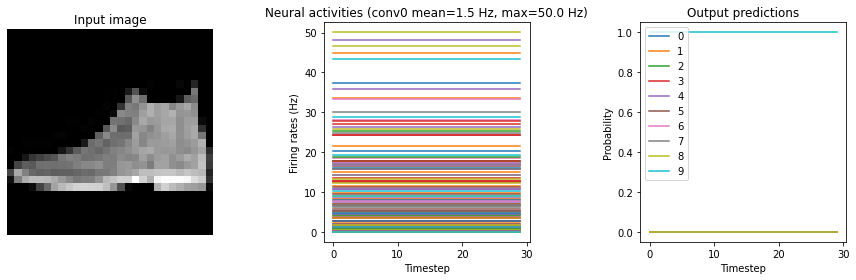

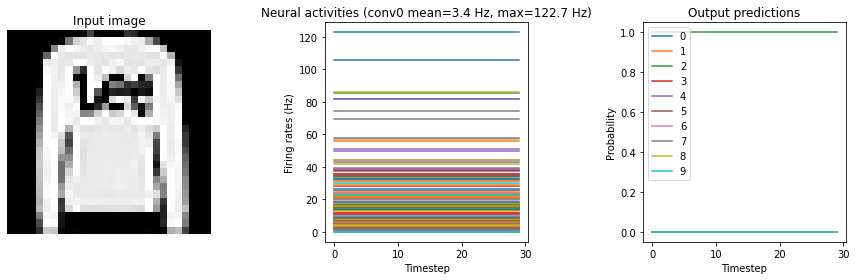

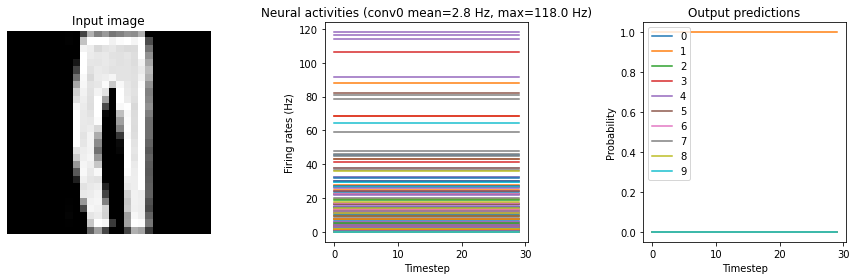

In [ ]:
log_str += "----------------Non-spiking neural network------------------\n"
for model in model_list:
  print("------------------------------------------")
  print("VGG version: " + model.name)
  log_str += "VGG version: " + model.name +" - accuracy: "
  acc = run_network(model = model, activation=nengo.RectifiedLinear())
  log_str += str(acc*100) + "%"
log_str += "----------------Spiking neural network------------------\n"


In [ ]:
for s in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]:
    print(f"Synapse={s:.3f}")
    run_network(
        model = model_list[0],
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=120,
        synapse=s,
    )
    plt.show()

Synapse=0.001
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
12


ValueError: ignored

In [ ]:
for model in model_list:
  log_str += "-----------------------------\n"
  log_str += "VGG VERSION: " + model.name  
  for s in [0.001, 0.005, 0.01, 0.02, 0.05]:
    for scale in [2,5,10,20]:
      print(f"Synapse={s:.3f}")
      print(f"Scale={scale:.3f}")
      acc = run_network(
          model = model,
          activation=nengo.SpikingRectifiedLinear(),
          n_steps=120,
          synapse=s,
          scale_firing_rates = scale
      )
      log_str += "\n[synapse, scale] =" + "[" + str(s) + "," + str(scale) + "]" + "- accuracy: " + str(acc*100) + "%\n"
      plt.show()


In [ ]:
with open ("/content/log.txt", "w") as log:
  log.write(log_str)

In [ ]:
print(log_str)

----------------Non-spiking neural network------------------
VGG version: vgg11 - accuracy: 92.0%----------------Spiking neural network------------------
-----------------------------
VGG VERSION: vgg11
[synapse, scale] =[0.001,2]- accuracy: 12.5%

[synapse, scale] =[0.001,5]- accuracy: 18.7%

[synapse, scale] =[0.001,10]- accuracy: 43.3%

[synapse, scale] =[0.001,20]- accuracy: 78.5%

[synapse, scale] =[0.005,2]- accuracy: 34.8%

[synapse, scale] =[0.005,5]- accuracy: 82.6%

[synapse, scale] =[0.005,10]- accuracy: 89.60000000000001%

[synapse, scale] =[0.005,20]- accuracy: 92.10000000000001%

[synapse, scale] =[0.01,2]- accuracy: 68.10000000000001%

[synapse, scale] =[0.01,5]- accuracy: 89.7%

[synapse, scale] =[0.01,10]- accuracy: 91.8%

[synapse, scale] =[0.01,20]- accuracy: 92.2%

[synapse, scale] =[0.02,2]- accuracy: 37.1%

[synapse, scale] =[0.02,5]- accuracy: 79.2%

[synapse, scale] =[0.02,10]- accuracy: 91.4%

[synapse, scale] =[0.02,20]- accuracy: 92.0%

[synapse, scale] =[0.0

Scale=2
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
17
Test accuracy: 10.75%


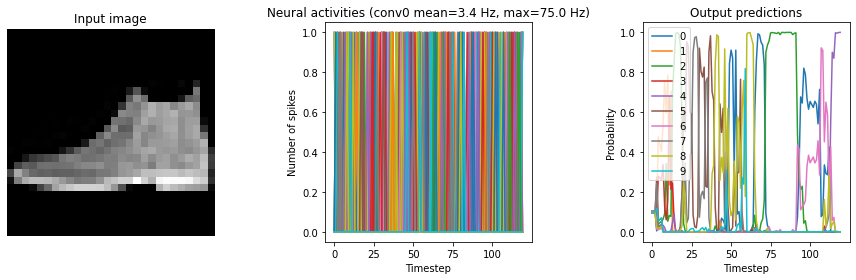

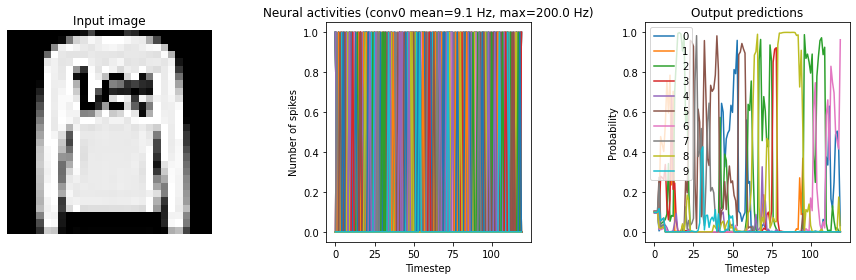

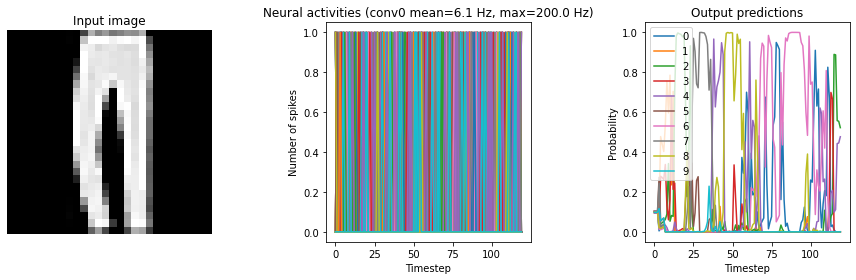

Scale=5
Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
17
Test accuracy: 9.75%


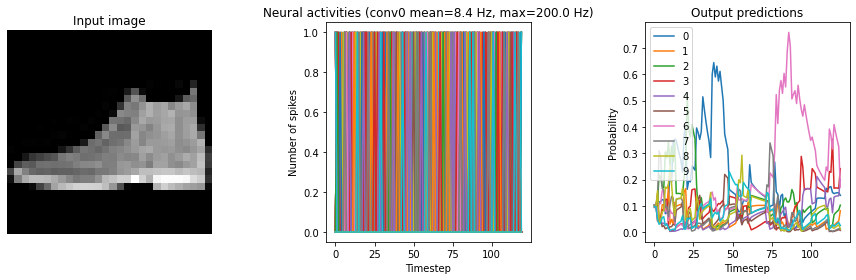

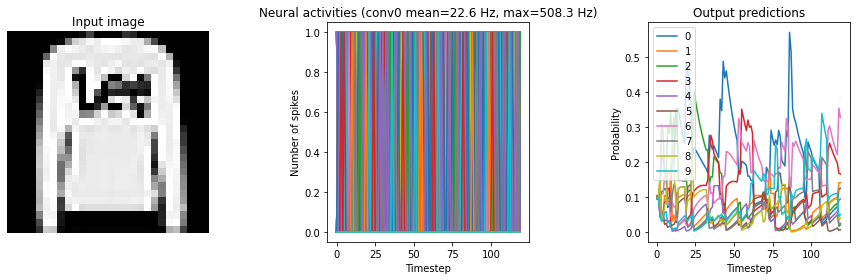

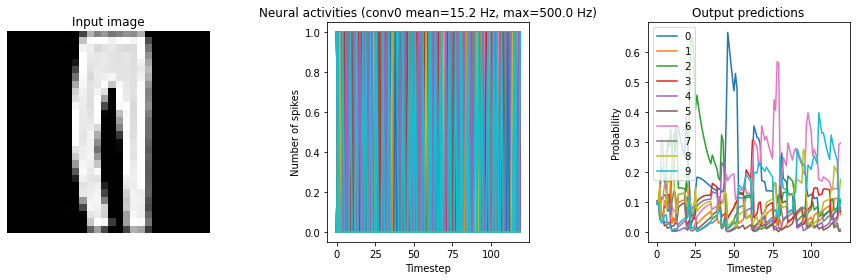

Scale=10
Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
17
Test accuracy: 9.00%


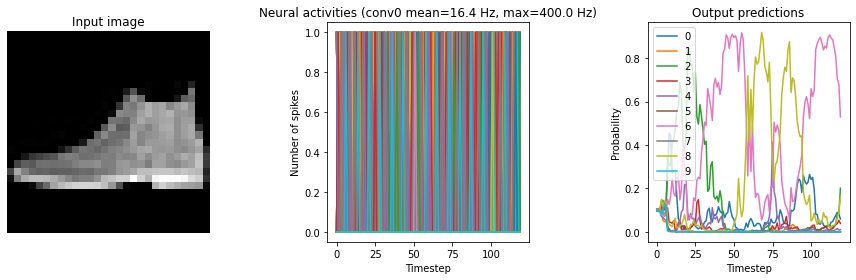

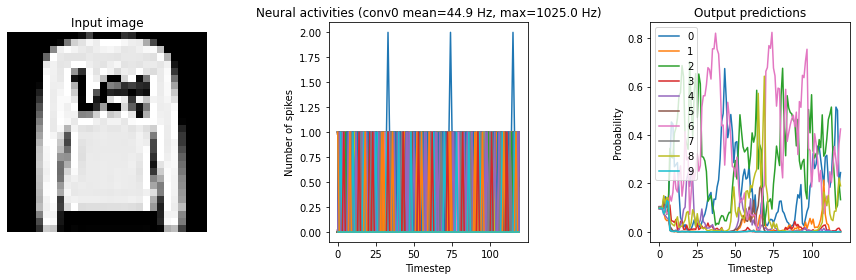

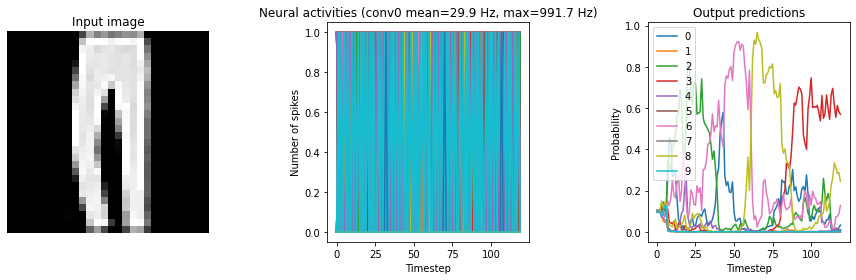

Scale=20
Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
17
Test accuracy: 13.50%


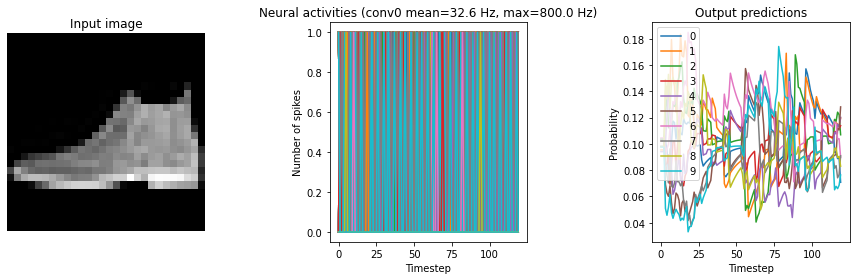

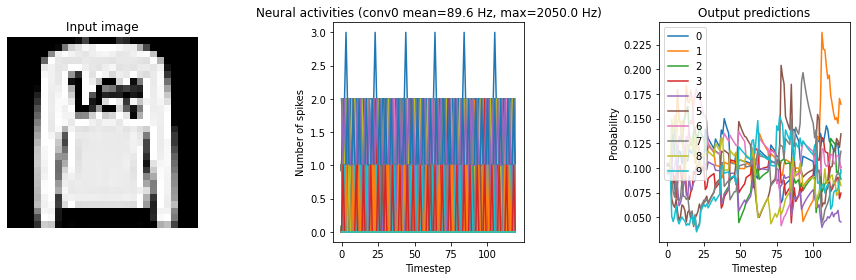

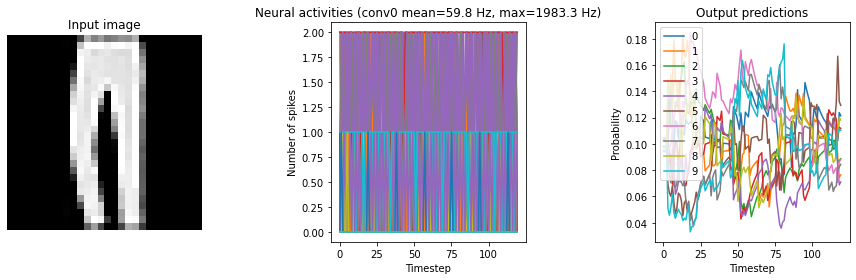

Scale=100
Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
17
Test accuracy: 7.00%


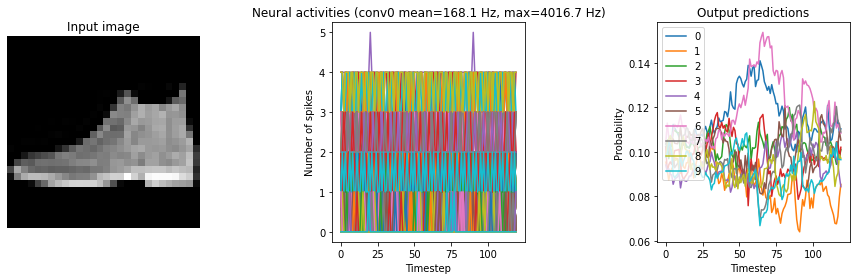

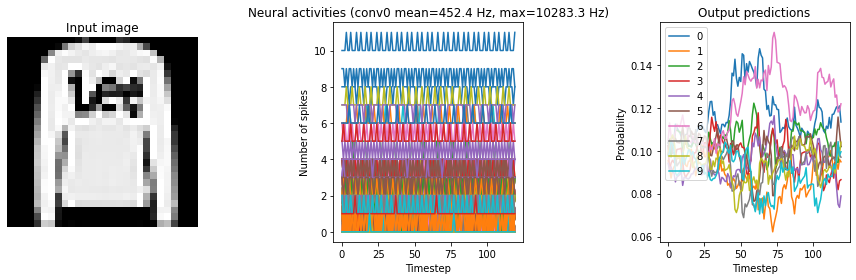

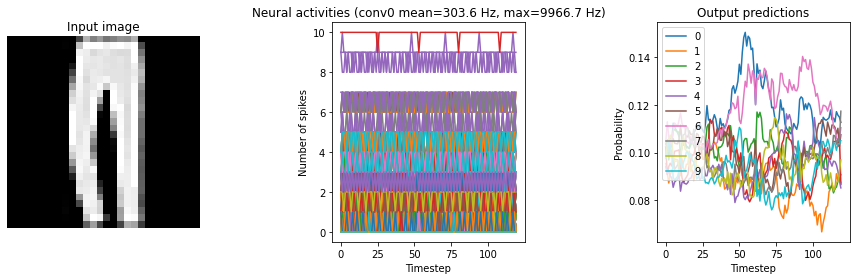

In [ ]:
for scale in [2, 5, 10, 20, 100]:
    print(f"Scale={scale}")
    run_network(
        model = model_list[0],
        activation=nengo.SpikingRectifiedLinear(),
        synapse = 0.01,
        scale_firing_rates=scale,
        n_steps = 120
    )
    plt.show()  

done
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
14
Test accuracy: 94.50%


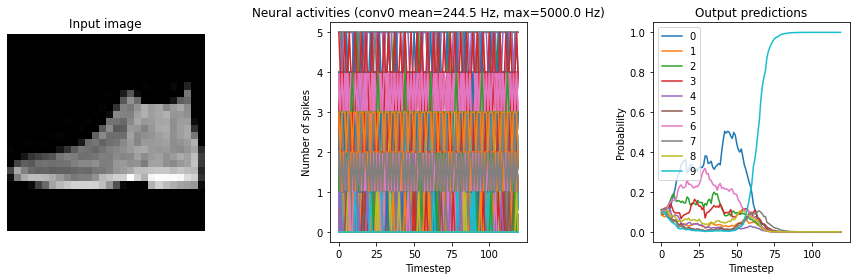

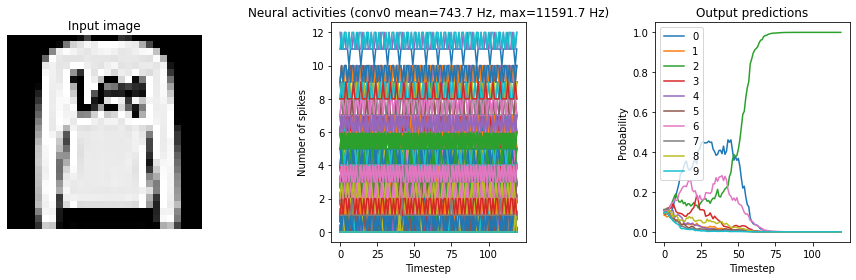

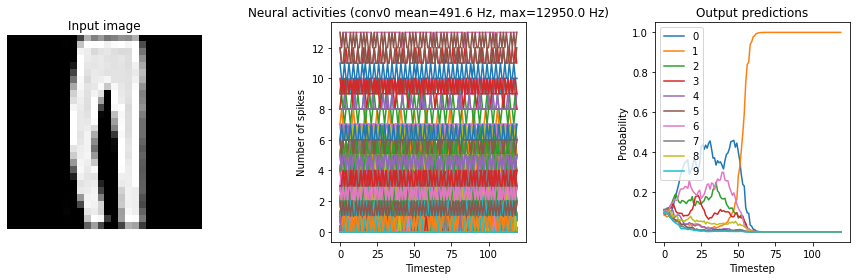

In [ ]:
# we'll encourage the neurons to spike at around 250Hz
target_rate = 100

# convert keras model to nengo network
converter = nengo_dl.Converter(model)

# add probes to the convolutional layers, which
# we'll use to apply the firing rate regularization
with converter.net:
    output_p = converter.outputs[output]
    conv0_p = nengo.Probe(converter.layers[conv0])
    conv1_p = nengo.Probe(converter.layers[conv9])

with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    # add regularization loss functions to the convolutional layers
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={
            output_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            conv0_p: tf.losses.mse,
            conv1_p: tf.losses.mse,
        },
        loss_weights={output_p: 1, conv0_p: 1e-3, conv1_p: 1e-3},
    )

    do_training = True
    if do_training:
        # run training (specifying the target rates for the convolutional layers)
        sim.fit(
            {converter.inputs[input]: train_images},
            {
                output_p: train_labels,
                conv0_p: np.ones((train_labels.shape[0], 1, conv0_p.size_in))
                * target_rate,
                conv1_p: np.ones((train_labels.shape[0], 1, conv1_p.size_in))
                * target_rate,
            },
            epochs=25,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_regularized_params")
    else:
        # download pretrained weights
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1xvIIIQjiA4UM9Mg_4rq_ttBH3wIl0lJx",
            "keras_to_snn_regularized_params.npz",
        )
        print("Loaded pretrained weights") 

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
